### 1. IMPORT LIBRARIES AND CIFAR 10, PREPARE DATA

In [1]:
# general
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
import time
import matplotlib.pyplot as plt
% matplotlib inline

# dataset
from keras.datasets import cifar10

# modeling tools
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


Check and Prepare Data:

In [2]:
# split data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# check data dimension
print('training data shape: {}'.format(x_train.shape))
print('test data shape: {}'.format(x_test.shape))

170500096/170498071 [==============================] - 132s 1us/step
training data shape: (50000, 32, 32, 3)
test data shape: (10000, 32, 32, 3)


In [3]:
# check labels
labels = []
for y in y_train.flatten():
    if y not in labels:
        labels.append(y)
print('training labels are: {}'.format(labels))
print('# labels: {}'.format(len(labels)))

training labels are: [6, 9, 4, 1, 2, 7, 8, 3, 5, 0]
# labels: 10


In [0]:
# Convert class vectors to one-hot encoded vectors.
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [0]:
# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)

x_train = np.reshape(x_train,(50000,3072))
x_test = np.reshape(x_test,(10000,3072))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalization of pixel values (to [0-1] range)

x_train /= 255
x_test /= 255

### 2. HELP FUNCTION

In [0]:
def plotAcc(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'lower right')
    
def plotLoss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc = 'upper right')

In [0]:
# get the best accuracy result

def getBest(record):
    max_acc = 0
    experiment = None
    for value in record.values():
        max_acc = max(max_acc, value[1])

    for key in record.keys():
        if record[key][1] == max_acc:
            experiment = key
      
    return max_acc, experiment, record[experiment][3]

In [0]:
# get the summary of all experiments

import pandas as pd

def get_allResult(record):
    df_result = pd.DataFrame()
    length = len(list(record.keys()))
    df_result['Experiment'] = list(record.keys())
    df_result['Loss'] = [list(record.values())[i][0] for i in range(length)]
    df_result['Accuracy'] = [list(record.values())[i][1] for i in range(length)]
    return df_result

### 3. EXPERIMENTS - TEST WITH OPTIMIZER & LR

#### 1. Set up hyperparameters for batchsize and epoch

In [0]:
list_batchSize = [32, 64, 128, 256, 512]

# set a big epoch to observe what performs the best
epochs = 100

#### 2. Control other conditions and hyperparameters

In [0]:
# set conditions
n_class = 10
input_dimension = 32*32*3


# use the best combo of optimizer and lr from optimizer experiment
optimizer = keras.optimizers.Adam(lr = 0.0003)

# use the best activation function from activation experiment
activation = 'relu'

# use the best configuration from config experiment
n_neuron = 256

dropout_rate = 0.2

# record hyper parameter information in dictionary                 
param_dict = {
        'num_neurons': 256,
        'num_layers': 2,
        'batch_size': 128,
        'dropout_rate': 0.2,
        'epochs': 20,
        'optimizer':'Adam with 0.0001 lr'
    }

#### 3. Set up experiment function

In [0]:
def experiment_batchSize(list_batchSize):
    
    record = {}    
    for i, batch_size in enumerate(list_batchSize):
        
        model = Sequential()
        model.add(Dense(n_neuron, activation = activation, input_dim = input_dimension))
        model.add(Dropout(dropout_rate))
        model.add(Dense(n_neuron, activation = activation))
        model.add(Dropout(dropout_rate))
        model.add(Dense(n_class, activation = 'softmax'))

        model.compile(optimizer = optimizer,
                      loss = 'categorical_crossentropy',
                      metrics = ['accuracy'])

        start = time.clock()
        exp_batchSize = model.fit(x_train, 
                                  y_train, 
                                  epochs = epochs, 
                                  batch_size = batch_size,
                                  verbose = 2,
                                  validation_data = (x_test, y_test))
        elapsed = (time.clock() - start)
        scores = model.evaluate(x_test, y_test, verbose=1)
        
        # record experiment information:
        record[str(list_batchSize[i])] = [scores[0], scores[1], elapsed, exp_batchSize]
        
        # print experiment name:
        print('*******************************************************')
        print('=======================================================')
        print('Experiment' + str(i) + ':'  + '\t' + str(list_batchSize[i]))
        print('=======================================================')
        # print all used parameters for this model
#         for i,j in param_dict.items():
#             print(str(i) + '\t' + str(j)) 
#             print('-------------------------------------------------------')
            
        # print running time used
        print('Time Used: {}'.format(elapsed))
        print('-------------------------------------------------------')
        
        # print best loss and accuracy result
        print('Test loss:', scores[0])
        print('-------------------------------------------------------')
        print('Test accuracy:', scores[1])
        
        print('*******************************************************')
        
    return record

#### 4. Experiment

In [20]:
record = experiment_batchSize(list_batchSize)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
 - 11s - loss: 1.9583 - acc: 0.2810 - val_loss: 1.8170 - val_acc: 0.3410
Epoch 2/100
 - 9s - loss: 1.7996 - acc: 0.3493 - val_loss: 1.6881 - val_acc: 0.3887
Epoch 3/100
 - 9s - loss: 1.7341 - acc: 0.3792 - val_loss: 1.6390 - val_acc: 0.4242
Epoch 4/100
 - 9s - loss: 1.6932 - acc: 0.3931 - val_loss: 1.5791 - val_acc: 0.4346
Epoch 5/100
 - 9s - loss: 1.6651 - acc: 0.4029 - val_loss: 1.5975 - val_acc: 0.4340
Epoch 6/100
 - 9s - loss: 1.6361 - acc: 0.4120 - val_loss: 1.5767 - val_acc: 0.4373
Epoch 7/100
 - 9s - loss: 1.6211 - acc: 0.4159 - val_loss: 1.5510 - val_acc: 0.4534
Epoch 8/100
 - 9s - loss: 1.6006 - acc: 0.4250 - val_loss: 1.5028 - val_acc: 0.4666
Epoch 9/100
 - 9s - loss: 1.5846 - acc: 0.4311 - val_loss: 1.5192 - val_acc: 0.4594
Epoch 10/100
 - 9s - loss: 1.5695 - acc: 0.4365 - val_loss: 1.5182 - val_acc: 0.4629
Epoch 11/100
 - 9s - loss: 1.5624 - acc: 0.4408 - val_loss: 1.4913 - val_acc: 0.4695
Epoch 12/100
 - 9s - lo

### 4. SUMMRIZE EXPERIMENTS RESULTS

#### 1. Best result

In [28]:
max_acc, experiment, history = getBest(record)
print('The Best Result is:')
max_acc, experiment

The Best Result is:


(0.5095, '32')

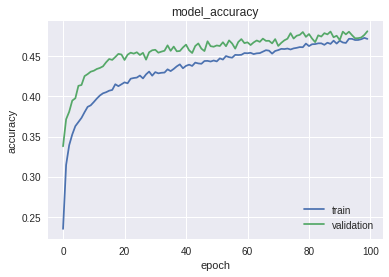

In [29]:
plotAcc(history)

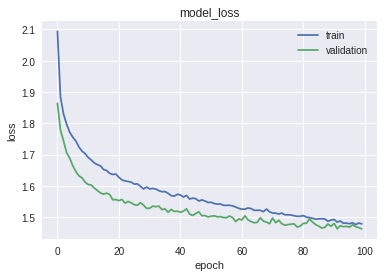

In [30]:
plotLoss(history)

#### 2. Result summary

In [0]:
df_result = get_allResult(record)

# add control parameters

df_result['activation'] = 'relu'
df_result['optimizer'] = 'Adam with learning rate @ 0.0003'
df_result['num_layers'] = 3
df_result['num_neurons'] = 256
df_result['dropout_rate'] = 0.2
df_result['epochs'] = 100

In [37]:
df_result.rename(columns = {"Experiment": "batch_size"}, inplace = True)
df_result.sort_values(by = 'Accuracy', axis = 0, ascending = False)

,batch_size,Loss,Accuracy,activation,optimizer,num_layers,num_neurons,dropout_rate,epochs
0,32,1.397282,0.5095,relu,Adam with learning rate @ 0.0003,3,256,0.2,100
3,256,1.408755,0.5000,relu,Adam with learning rate @ 0.0003,3,256,0.2,100
2,128,1.458573,0.4854,relu,Adam with learning rate @ 0.0003,3,256,0.2,100
1,64,1.467048,0.4839,relu,Adam with learning rate @ 0.0003,3,256,0.2,100
4,512,1.462792,0.4812,relu,Adam with learning rate @ 0.0003,3,256,0.2,100


In [0]:
df_result.to_csv('exe_batchSize_epoch.csv', index = False)